In [ ]:
# Copyright 2023 DeepMind Technologies Limited
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Imports

In [ ]:
!pip install --upgrade https://github.com/google-deepmind/nuclease-design.git


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from nuclease_design import utils
from nuclease_design import plotting
from nuclease_design import constants


# Load data

In [ ]:
RANDOM_SEED = 226
DATA_DIR = constants.DATA_DIR

In [ ]:
%%time
all_data_df = utils.load_all_data(DATA_DIR)
df = utils.expand_sublibraries(all_data_df)
df['campaign'] = df['sublibrary_name'].apply(utils.sublibrary_name_to_campaign_name)

CPU times: user 2.97 s, sys: 1.05 s, total: 4.02 s
Wall time: 4.86 s


# Hit-rate per radius

(4.0, 15.6)

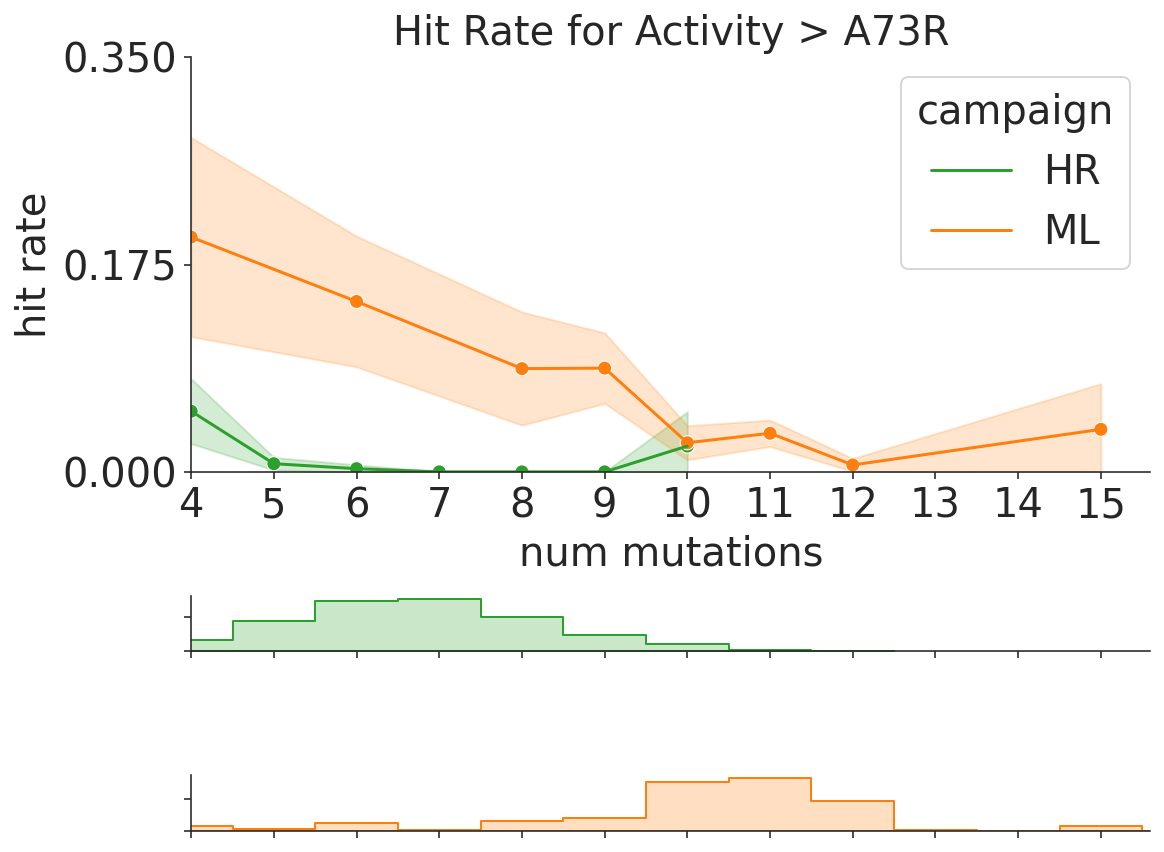

In [ ]:
fig = plt.figure(figsize=(8, 6))

systems = ['g4_mbo_dnn', 'g4_hit_recombination']
ax = plotting.plot_hit_rate_per_num_mutations_with_histogram(df[df['sublibrary_name'].isin(systems)],
    reference_name='a73r',
    hue_feature='campaign',
    hue_order=['HR', 'ML'],
    palette=[plotting.HR_COLOR, plotting.ML_COLOR],
    group_cols=['campaign', 'num_mutations'],
    random_seed=RANDOM_SEED)


ax.set_yticks(np.linspace(0, 0.35, 3))
ax.set_xlim(left=4.0)


In [ ]:
def make_plot(df, systems, reference, palette=None, rename_dict=None):
    plt.figure(figsize=(12, 10))

    df = df.copy()
    df['library'] = df['sublibrary_name']
    if rename_dict is not None:
      df = df.copy()
      df['library'] = df['library'].apply(lambda s: rename_dict.get(s, s))
      systems = [rename_dict[s] for s in systems]
    ax = plotting.plot_hit_rate_per_num_mutations_with_histogram(
        df[df['library'].isin(systems)],
        reference_name=reference,
        hue_feature='library',
        hue_order=systems,
        palette=palette,
        group_cols=['library', 'num_mutations'],
        random_seed=RANDOM_SEED,
        fontsize=30
    )
    return ax

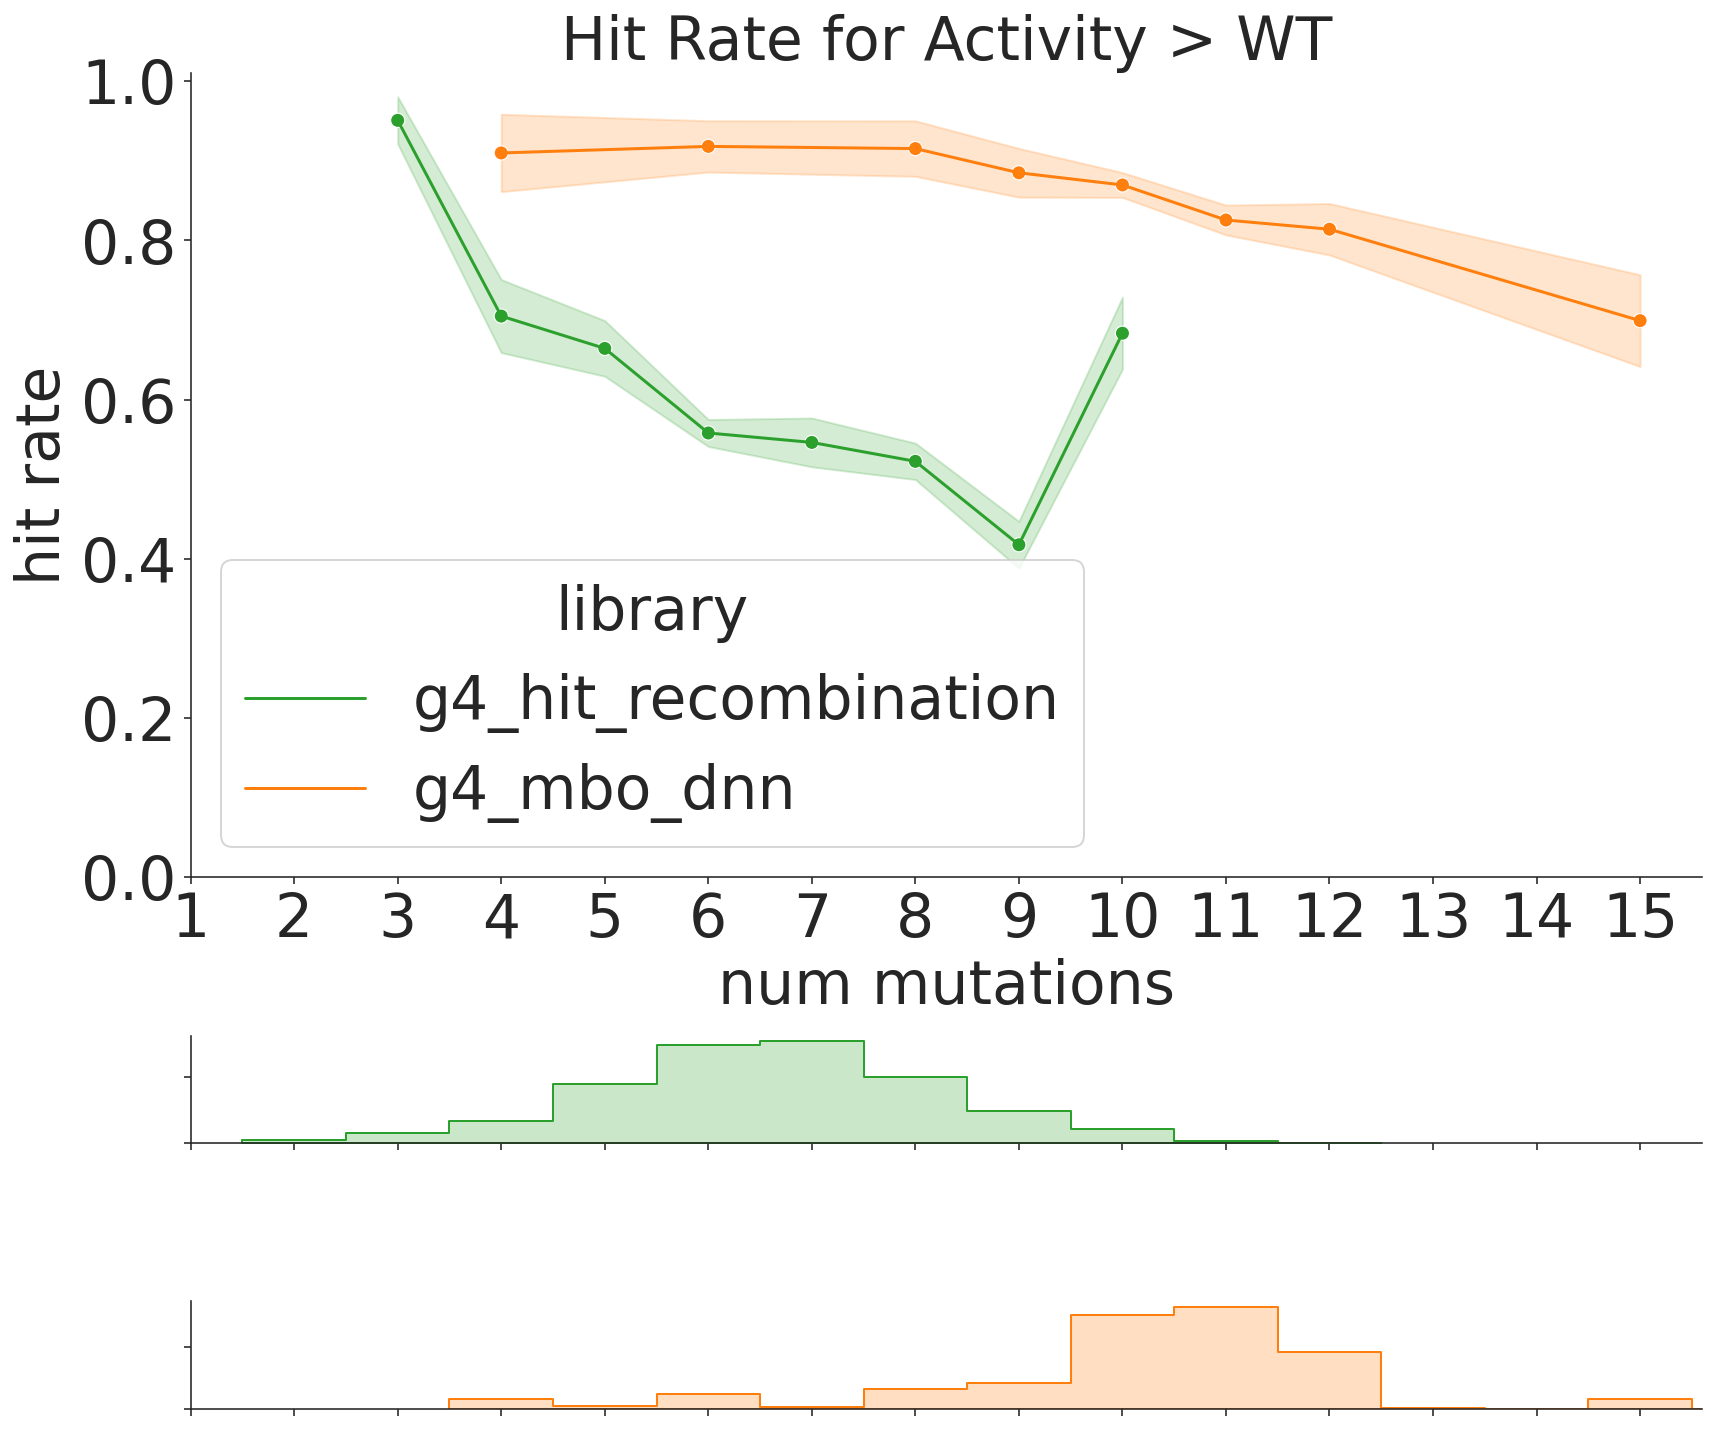

In [ ]:
ax = make_plot(df, ['g4_hit_recombination', 'g4_mbo_dnn'], 'wt', [plotting.HR_COLOR, plotting.ML_COLOR])

# Make big tables of hit rates stats to put in the Supplement

In [ ]:
stats_dfs = {}
stats_dfs['neg_control'] = utils.get_bootstrapped_hit_rate_stats(
    df,
    'neg_control',
    random_seed=RANDOM_SEED,
)

stats_dfs['wt'] = utils.get_bootstrapped_hit_rate_stats(
    df,
    'wt',
    random_seed=RANDOM_SEED,
)

stats_dfs['A73R'] = utils.get_bootstrapped_hit_rate_stats(
    df[df['generation'].isin(['g3', 'g4'])],
    'a73r',
    random_seed=RANDOM_SEED,
)


for fiducial in ['a73r_d74s', 'a63p_a73r_d74h_i84y']:
  stats_dfs[fiducial] = utils.get_bootstrapped_hit_rate_stats(
      df[df['generation'] == 'g4'],
      fiducial,
      random_seed=RANDOM_SEED,
  )

In [ ]:
def _render_with_errorbar(row, field, num_decimals, use_percentage) -> str:
  format_str = f'%0.0{num_decimals}f +/- %0.0{num_decimals}f'
  factor = 100 if use_percentage else 1
  return format_str % (factor * row[(field, 'mean')], factor * row[(field, 'std')])


def _render_stats_table(hit_rate_stats_df) -> str:
  rows = []
  for raw_row in hit_rate_stats_df.reset_index().to_dict('records'):
    row = dict(name=raw_row[('sublibrary_name', '')])
    row['num hits'] = _render_with_errorbar(raw_row, 'num_hits', 1, use_percentage=False)
    row['hit rate'] = _render_with_errorbar(raw_row, 'hit_rate', 2, use_percentage=True)
    row['library size'] = int(raw_row[('library_size', 'mean')])
    rows.append(row)
  return pd.DataFrame(rows)


def _format_columns(df, ref_name):
  return df.rename(
      columns={key: f'{key} (> {ref_name})' for key in ['num hits', 'hit rate']}
  )


def make_table(stats_dfs, group_order, name_to_generation):
  stats_dfs = {
      key: _format_columns(_render_stats_table(df), key)
      for key, df in stats_dfs.items()
  }
  to_return = stats_dfs[group_order[0]]
  for group in group_order[1:]:
    to_return = to_return.merge(
        stats_dfs[group].drop(columns='library size'), on='name', how='outer'
    ).fillna('N/A')

  to_return['generation'] = to_return['name'].apply(name_to_generation.get)
  first_columns = ['generation', 'name', 'library size']
  col_order = first_columns + [c for c in to_return.columns if c not in first_columns]
  return to_return[col_order]


In [ ]:
name_to_generation = df.groupby('sublibrary_name')['generation'].first().to_dict()
name_to_generation['zero_shot'] = 'alternative to g1'
name_to_generation['prosar+screen_g2_redux'] = 'alternative to g2'

table = make_table(stats_dfs, ['neg_control', 'wt', 'A73R'], name_to_generation)
table.head()

,generation,name,library size,num hits (> neg_control),hit rate (> neg_control),num hits (> wt),hit rate (> wt),num hits (> A73R),hit rate (> A73R)
0,g1,g1_eppcr,9441,1084.5 +/- 33.0,11.49 +/- 0.35,155.1 +/- 10.0,1.64 +/- 0.11,N/A,N/A
1,g2,g2_broad_recombination_sampling,3598,99.5 +/- 9.5,2.76 +/- 0.26,6.1 +/- 3.5,0.17 +/- 0.10,N/A,N/A
2,g2,g2_g1_plate_assay_variants,5,5.0 +/- 0.0,100.00 +/- 0.00,3.7 +/- 0.9,73.33 +/- 17.99,N/A,N/A
3,g2,g2_hit_recombination,951,830.9 +/- 12.5,87.37 +/- 1.32,470.0 +/- 10.1,49.42 +/- 1.06,N/A,N/A
4,g2,g2_mbo_dnn_exploit,287,104.5 +/- 9.7,36.40 +/- 3.37,43.1 +/- 7.5,15.03 +/- 2.63,N/A,N/A


In [ ]:
# TO put this table in the paper:
# 1) paste the text into a local csv file
# 2) upload the file to google sheets
# 3) paste the sheet as a table in the paper
print(table.to_csv(index=False, header=True))

generation,name,library size,num hits (> neg_control),hit rate (> neg_control),num hits (> wt),hit rate (> wt),num hits (> A73R),hit rate (> A73R)
g1,g1_eppcr,9441,1084.5 +/- 33.0,11.49 +/- 0.35,155.1 +/- 10.0,1.64 +/- 0.11,N/A,N/A
g2,g2_broad_recombination_sampling,3598,99.5 +/- 9.5,2.76 +/- 0.26,6.1 +/- 3.5,0.17 +/- 0.10,N/A,N/A
g2,g2_g1_plate_assay_variants,5,5.0 +/- 0.0,100.00 +/- 0.00,3.7 +/- 0.9,73.33 +/- 17.99,N/A,N/A
g2,g2_hit_recombination,951,830.9 +/- 12.5,87.37 +/- 1.32,470.0 +/- 10.1,49.42 +/- 1.06,N/A,N/A
g2,g2_mbo_dnn_exploit,287,104.5 +/- 9.7,36.40 +/- 3.37,43.1 +/- 7.5,15.03 +/- 2.63,N/A,N/A
g2,g2_mbo_dnn_explore,4083,1393.9 +/- 27.3,34.14 +/- 0.67,171.7 +/- 20.0,4.20 +/- 0.49,N/A,N/A
g2,g2_single_mutants,1402,384.4 +/- 12.7,27.42 +/- 0.91,43.0 +/- 6.3,3.07 +/- 0.45,N/A,N/A
g2,g2_stratified_sample,40,16.2 +/- 3.6,40.50 +/- 9.12,2.7 +/- 1.7,6.83 +/- 4.27,N/A,N/A
g2,g2_unmatched,4365,446.8 +/- 18.3,10.24 +/- 0.42,103.9 +/- 11.8,2.38 +/- 0.27,N/A,N/A
g2,g2_wt_synonyms,1,1

In [ ]:
stats_dfs['a73r_d74s'][('num_hits', 'mean')]

sublibrary_name
g4_a73r_synonyms                0.000000
g4_double_synonyms              0.000000
g4_g3_hit_constituents          0.000000
g4_g3_plate_assay_variants      0.000000
g4_hit_recombination            1.400000
g4_homolog_graft                0.000000
g4_mbo_dnn                     29.133333
g4_mbo_linear                   0.000000
g4_mbo_seeds                    0.466667
g4_other                        0.000000
g4_quad_synonyms                1.000000
g4_sample_and_screen_dnn        1.866667
g4_sample_and_screen_linear     0.000000
g4_sample_unscreened            0.000000
g4_unmatched                    0.000000
g4_wt_synonyms                  0.000000
prosar+screen_g2_redux          0.000000
zero_shot                       0.000000
Name: (num_hits, mean), dtype: float64

In [ ]:
stats_dfs['a73r_d74s'][stats_dfs['a73r_d74s'][('num_hits', 'mean')] > 0]

num_hits            ... library_size     
                               mean       std  ...         mean  std
sublibrary_name                                ...                  
g4_hit_recombination       1.400000  2.063284  ...       1540.0  0.0
g4_mbo_dnn                29.133333  6.885457  ...       1356.0  0.0
g4_mbo_seeds               0.466667  1.245946  ...         27.0  0.0
g4_quad_synonyms           1.000000  0.000000  ...          1.0  0.0
g4_sample_and_screen_dnn   1.866667  1.552264  ...       1298.0  0.0

[5 rows x 6 columns]

In [ ]:
table = make_table(dict(a73r_d74s=stats_dfs['a73r_d74s'][stats_dfs['a73r_d74s'][('num_hits', 'mean')] > 0]), ['a73r_d74s'], name_to_generation)
print(table.to_csv(index=False, header=True))

generation,name,library size,num hits (> a73r_d74s),hit rate (> a73r_d74s)
g4,g4_hit_recombination,1540,1.4 +/- 2.1,0.09 +/- 0.13
g4,g4_mbo_dnn,1356,29.1 +/- 6.9,2.15 +/- 0.51
g4,g4_mbo_seeds,27,0.5 +/- 1.2,1.73 +/- 4.61
g4,g4_quad_synonyms,1,1.0 +/- 0.0,100.00 +/- 0.00
g4,g4_sample_and_screen_dnn,1298,1.9 +/- 1.6,0.14 +/- 0.12



In [44]:
df[df['activity_greater_than_a73r_d74s'].fillna(False)]['sublibrary_name'].value_counts()

sublibrary_name
g4_mbo_dnn                  23
g4_sample_and_screen_dnn     2
g4_other                     1
g4_unmatched                 1
g4_hit_recombination         1
Name: count, dtype: int64

In [62]:
# This cell is used to generate stats for the 'extrapolation' section where
# we report on the small number of hits found to have activity higher than
# the A73R,D74S fiducial. Note that the number of hits for g4_hit_recombination
# at this activity level is very low. The bootrapping-based computation of hit
# rates above occasionally finds hits for g4_hit_recombination, but not always.
# Therefore, when analyzing these hits, we use a higher
# expected_false_discovery_rate than everywhere else in the notebook.

for group, group_df in df[df['generation'] == 'g4'].groupby('sublibrary_name'):
  selected_df = utils.select_hit_rows(group_df, 'a73r_d74s', expected_false_discovery_rate=0.25)
  if not selected_df.empty:
    print(group)
    print(selected_df['num_mutations'].value_counts().sort_index())
    print('')

g4_hit_recombination
num_mutations
4    2
Name: count, dtype: int64

g4_mbo_dnn
num_mutations
4      5
5      1
6      5
8      2
9      4
10     8
11    12
12     2
Name: count, dtype: int64

g4_quad_synonyms
num_mutations
4    1
Name: count, dtype: int64

g4_sample_and_screen_dnn
num_mutations
12    2
Name: count, dtype: int64



In [ ]:
table = make_table(stats_dfs, ['a63p_a73r_d74h_i84y'], name_to_generation)
table

,generation,name,library size,num hits (> a63p_a73r_d74h_i84y),hit rate (> a63p_a73r_d74h_i84y)
0,g4,g4_a73r_synonyms,1,0.0 +/- 0.0,0.00 +/- 0.00
1,g4,g4_double_synonyms,1,0.0 +/- 0.0,0.00 +/- 0.00
2,g4,g4_g3_hit_constituents,241,0.0 +/- 0.0,0.00 +/- 0.00
3,g4,g4_g3_plate_assay_variants,14,0.0 +/- 0.0,0.00 +/- 0.00
4,g4,g4_hit_recombination,1540,0.0 +/- 0.0,0.00 +/- 0.00
5,g4,g4_homolog_graft,11,0.0 +/- 0.0,0.00 +/- 0.00
6,g4,g4_mbo_dnn,1356,3.1 +/- 2.5,0.23 +/- 0.18
7,g4,g4_mbo_linear,280,0.0 +/- 0.0,0.00 +/- 0.00
8,g4,g4_mbo_seeds,27,0.0 +/- 0.0,0.00 +/- 0.00
9,g4,g4_other,4494,0.0 +/- 0.0,0.00 +/- 0.00
